In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import XLMRobertaTokenizerFast
from datasets import Dataset, Features, Sequence, Value
from transformers import TrainingArguments
from transformers import XLMRobertaForTokenClassification, AutoModelForTokenClassification, AutoTokenizer, Trainer

In [ ]:
from google.colab import files
import pandas as pd

# Function to load CoNLL formatted data
def load_conll(file_path):
    sentences = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        sentence = []
        label = []
        for line in f:
            if line.strip():  # Non-empty line
                token, label_item = line.split()
                sentence.append(token)
                label.append(label_item)
            else:  # Empty line indicates end of a sentence
                sentences.append(sentence)
                labels.append(label)
                sentence = []
                label = []
    return pd.DataFrame({'tokens': sentences, 'labels': labels})

# Upload your CoNLL file
uploaded = files.upload()

# Load your CoNLL file
df = load_conll('labeled_data_conll.conll')

Saving labeled_data_conll.conll to labeled_data_conll.conll


In [ ]:
# Explore the first few rows
df.head(10)

,tokens,labels
0,"[40414243, 3500, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, መዚድ, ላዛ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[ለጥምቀት, እንዲሁም, ለተለያዩ, በዓላት, ወይም, ሮግራም, የሚሆኑ, 4...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[40414243, 3800, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, መዚድ, ላዛ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,"[40414243, 3400, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, መዚድ, ላዛ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,"[414243, 3600, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, መዚድ, ላዛ, የ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
5,"[40414243, 3500, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, መዚድ, ላዛ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
6,"[40414243, 3600, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, መዚድ, ላዛ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
7,"[ለጥምቀት, እንዲሁም, ለተለያዩ, በዓላት, ወይም, ሮግራም, የሚሆኑ, 4...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
8,"[2000, 4041424344, 3500, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,"[40414243, 3400, አድራሻሜክሲኮ, ኮሜርስ, ጀርባ, መዚድ, ላዛ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


In [ ]:
unique_labels = set(label for sublist in df['labels'] for label in sublist)
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

In [ ]:
unique_labels

{'B-LOCATION', 'B-PRICE', 'B-PRODUCT', 'I-PRICE', 'O'}

In [ ]:
df['labels'] = df['labels'].apply(lambda x: [label2id[label] for label in x])

In [ ]:
# Convert DataFrame to Hugging Face Dataset
# Make sure 'labels' is a list of lists
# Define the features with the correct data types
features = Features({
    'tokens': Sequence(Value('string')),  # List of strings for tokens
    'labels': Sequence(Value('int32'))    # List of integers for labels
})

# Convert DataFrame to Hugging Face Dataset with specified features
dataset = Dataset.from_pandas(df[['tokens', 'labels']], features=features)

In [ ]:
# Initialize the Fast Tokenizer
# Use the fast tokenizer
# For XLM-Roberta
tokenizer = XLMRobertaTokenizerFast.from_pretrained(
    "xlm-roberta-base",
    clean_up_tokenization_spaces=True
    )

# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Tokenize the dataset using xlrm_berta

tokenized_xlm_dataset = dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

In [ ]:
# For mBERT
tokenizer_mbert = AutoTokenizer.from_pretrained(
    'bert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_mbert(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Tokenize the dataset using xlrm_berta

tokenized_mbert_dataset = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

In [ ]:
#Tokenize the dataset using DistilBERT
# For DistilBERT
tokenizer_distilbert = AutoTokenizer.from_pretrained(
    'distilbert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_distilbert(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

tokenized_distilbert_dataset = dataset.map(tokenize_and_align_labels, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

In [ ]:
# Split into train and validation datasets
train_test_split_xlm = tokenized_xlm_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_mbert = tokenized_mbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_distilbert = tokenized_distilbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation

In [ ]:
# Set up training arguments with adjustments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",     # Evaluates at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01,               # Strength of weight decay
    max_grad_norm=1.0,  # Gradient clipping
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="steps",        # Log at regular intervals
    logging_steps=50,                # Log every 50 steps
    save_strategy="epoch",           # Save model at the end of each epoch
    report_to="none",                # Only show logs in the output (no TensorBoard)
    use_cpu=True,  # Force training to happen on CPU,
    load_best_model_at_end=True,     # Load the best model (based on metric) at the end
    metric_for_best_model="eval_loss",# Metric used to determine the best model
    save_total_limit=1,              # Only keep the best model, delete the others

)

In [ ]:
# Initialize each of the models
# For XLM-Roberta
model_xlmr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(unique_labels)) # Ensure unique_labels is defined

# For DistilBERT
model_distilbert = AutoModelForTokenClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=len(unique_labels))

# For mBERT
model_distilbert = AutoModelForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(unique_labels))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the function to compute evaluation metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_labels = [[label for label in label_row if label != -100] for label_row in labels]
    predicted_labels = [[pred for pred, true in zip(pred_row, true_row) if true != -100] for pred_row, true_row in zip(predictions, labels)]

    # Flatten the lists
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    predicted_labels_flat = [item for sublist in predicted_labels for item in sublist]

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=True)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
trainer_xlmr = Trainer(
    model=model_xlmr,
    args=training_args,
    train_dataset=train_test_split_xlm['train'],
    eval_dataset=train_test_split_xlm['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)
trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_mbert['train'],
    eval_dataset=train_test_split_mbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)
trainer_mbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_distilbert['train'],
    eval_dataset=train_test_split_distilbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)

In [ ]:
# Fine-tune XLM-Roberta
print('For XLM-Roberta')
trainer_xlmr.train()

# Fine-tune DistilBERT
print('For DistilBERT')
trainer_distilbert.train()


# Fine-tune mBERT
print('For mBERT')
trainer_mbert.train()

For XLM-Roberta


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.138686,0.976126,0.975527,0.963443
2,No log,0.106409,0.976126,0.975527,0.963443
3,0.318700,0.081444,0.976126,0.975527,0.963443


For DistilBERT


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.169912,0.967977,0.966880,0.950599
2,No log,0.160895,0.967977,0.966880,0.950599
3,0.181400,0.154136,0.967977,0.966880,0.950599


For mBERT


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.054394,0.986275,0.981514,0.979033
2,No log,0.034176,0.988193,0.984155,0.985687


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.054394,0.986275,0.981514,0.979033
2,No log,0.034176,0.988193,0.984155,0.985687
3,0.079600,0.030754,0.989941,0.988556,0.989045


TrainOutput(global_step=60, training_loss=0.07617452045281728, metrics={'train_runtime': 2195.6683, 'train_samples_per_second': 0.422, 'train_steps_per_second': 0.027, 'total_flos': 60557165809920.0, 'train_loss': 0.07617452045281728, 'epoch': 3.0})

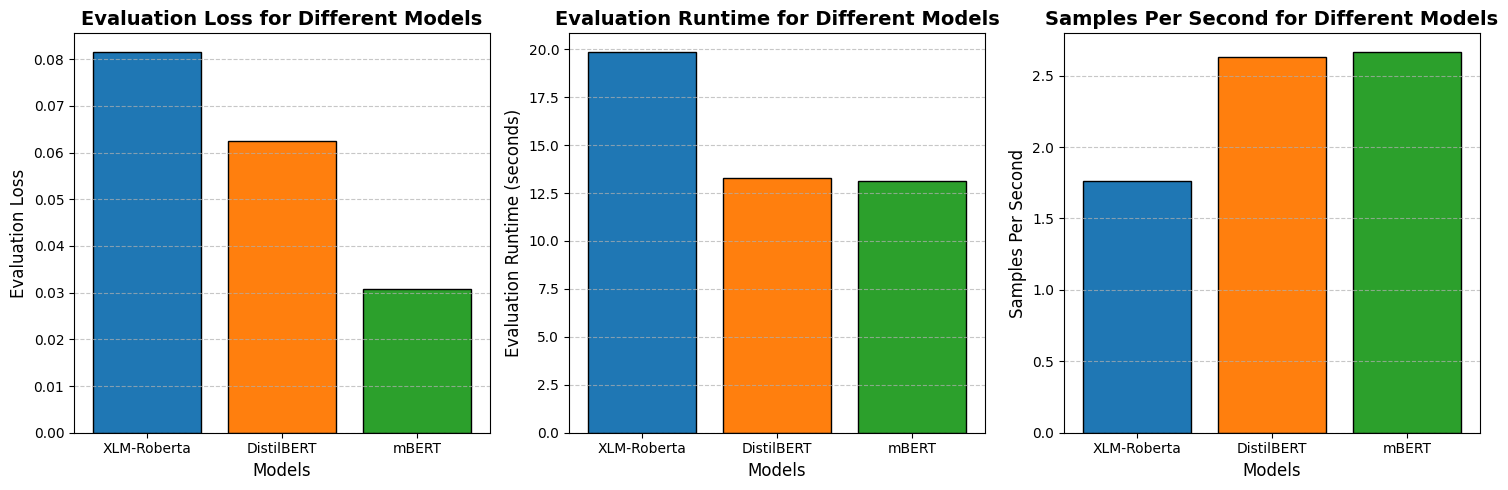

In [ ]:
# Create a dictionary to hold the results
results = {}

# Evaluate each model and store the results
results['XLM-Roberta'] = trainer_xlmr.evaluate()
results['DistilBERT'] = trainer_distilbert.evaluate()
results['mBERT'] = trainer_mbert.evaluate()

# Extracting the relevant metrics
eval_loss = [results[model]['eval_loss'] for model in results]
eval_runtime = [results[model]['eval_runtime'] for model in results]
samples_per_second = [results[model]['eval_samples_per_second'] for model in results]

# Visualization for Evaluation Metrics
plt.figure(figsize=(15, 5))

# Plotting Evaluation Loss
plt.subplot(1, 3, 1)
plt.bar(
    results.keys(),
    eval_loss,
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Vibrant colors
    edgecolor='black'
)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Evaluation Loss', fontsize=12)
plt.title('Evaluation Loss for Different Models', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plotting Evaluation Runtime
plt.subplot(1, 3, 2)
plt.bar(
    results.keys(),
    eval_runtime,
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Vibrant colors
    edgecolor='black'
)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Evaluation Runtime (seconds)', fontsize=12)
plt.title('Evaluation Runtime for Different Models', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plotting Samples Per Second
plt.subplot(1, 3, 3)
plt.bar(
    results.keys(),
    samples_per_second,
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Vibrant colors
    edgecolor='black'
)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Samples Per Second', fontsize=12)
plt.title('Samples Per Second for Different Models', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

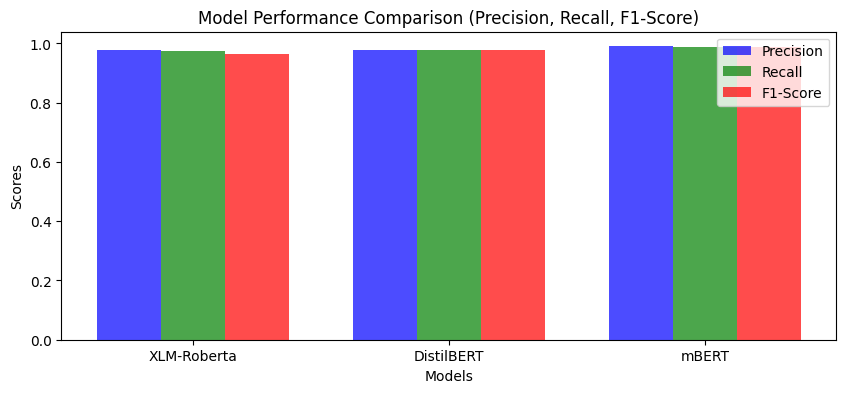

In [ ]:
# Extract data
models = list(results.keys())
precision_scores = [results[model]['eval_precision'] for model in models]
recall_scores = [results[model]['eval_recall'] for model in models]
f1_scores = [results[model]['eval_f1'] for model in models]

# Plot
plt.figure(figsize=(10, 4))
bar_width = 0.25
bar_positions = range(len(models))

plt.bar(bar_positions, precision_scores, bar_width, color='blue', alpha=0.7, label='Precision')
plt.bar([p + bar_width for p in bar_positions], recall_scores, bar_width, color='green', alpha=0.7, label='Recall')
plt.bar([p + 2 * bar_width for p in bar_positions], f1_scores, bar_width, color='red', alpha=0.7, label='F1-Score')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison (Precision, Recall, F1-Score)')
plt.xticks([p + bar_width for p in bar_positions], models)
plt.legend()
plt.show()

In [ ]:
# Find the model with the highest F1 score
best_model_name = max(results, key=lambda model: results[model]['eval_f1'])
print(f"The best model is: {best_model_name}")
model_name = 'xlm-roberta-base'
# Load the best model
# best_model = AutoModelForTokenClassification.from_pretrained(model_name, token=token)
# Save the best model to a directory
#save_directory = f"./{best_model_name}_fine_tuned"
save_directory = "/content/best_model"
# best_model.save_pretrained(save_directory)
print(f"Model saved to {save_directory}")

The best model is: mBERT


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to /content/best_model
